In [1]:
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from os import listdir
from collections import namedtuple
#has package pillow as a dependency. Is needed to give scipy image operations. 
from scipy import misc
import scipy

In [2]:
'''Load data'''

IMAGE_FOLDER = "../data/anime wallpapers"
image_png_names = listdir(IMAGE_FOLDER + "/png")
image_jpg_names = listdir(IMAGE_FOLDER + "/jpg")
image_png_paths = [IMAGE_FOLDER + '/png/' + name for name in image_png_names]
image_jpg_paths = [IMAGE_FOLDER + '/jpg/' + name for name in image_jpg_names]

In [3]:
'''Define functions'''

Dimensions = namedtuple('Dimensions', ['h', 'w'])

def show_image(image):
        plt.matshow(image, cmap=plt.cm.gray)
        
def minibatch_image_generator(image_filenames, batch_size):
    epoch = 0 
    while 1:
        scrambled_images = np.random.permutation([misc.imread(img) for img in image_filenames])
        for batch_number in range(int(np.ceil(len(scrambled_images)/batch_size))):
            start_index = batch_number*batch_size
            end_index = min(len(scrambled_images),start_index+batch_size)
            yield epoch, scrambled_images[start_index:end_index]
        epoch = epoch + 1
        
def weight_variable(shape, stddev=0.1):
  initial = tf.truncated_normal(shape, stddev=stddev)
  return tf.Variable(initial)

def _glorot_initializer(prev_units, num_units, stddev_factor=1.0):
    """Initialization in the style of Glorot 2010.

    stddev_factor should be 1.0 for linear activations, and 2.0 for ReLUs"""
    stddev  = np.sqrt(stddev_factor / np.sqrt(prev_units*num_units))
    return tf.truncated_normal([prev_units, num_units],
                                mean=0.0, stddev=stddev)

def _glorot_initializer_conv2d(prev_units, num_units, mapsize, stddev_factor=1.0):
    """Initialization in the style of Glorot 2010.

    stddev_factor should be 1.0 for linear activations, and 2.0 for ReLUs"""

    stddev  = np.sqrt(stddev_factor / (np.sqrt(prev_units*num_units)*mapsize*mapsize))
    return tf.truncated_normal([mapsize, mapsize, prev_units, num_units],
                                mean=0.0, stddev=stddev)

def bias_variable(shape, stddev=0.1):
    #TODO: stddev arg has no effect
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W, stride_input = [1, 2, 2, 1]):
  return tf.nn.conv2d(x, W, strides = stride_input, padding='SAME')

def relu(input, leak = 0.2):
    #TODO: implement leaky relu

    return tf.nn.relu(input)

def full_conv2d(input_tensor, f_in, f_out, mapsize=3, stride=1, stddev_factor=0.1, weights=None):
    if weights == None:
        (weight,bias) = conv2d_wb_initiator(f_in, f_out, mapsize=mapsize)
    else: 
        (weight,bias) = weights
    return conv2d(input_tensor, weight, stride_input = [1, stride, stride, 1]) + bias

def conv2d_wb_initiator(f_in, f_out, mapsize=3, stddev_factor=0.1):
    return weight_variable([mapsize, mapsize, f_in, f_out],stddev=stddev_factor), bias_variable([f_out],stddev=stddev_factor)

def batch_norm(input_tensor, scale=False):
    return tf.contrib.layers.batch_norm(input_tensor, scale=scale)

def add_residual_block(input_tensor, f_in, f_internal, mapsize=3, num_layers=2,\
                       stddev_factor=1e-3, relu_pre_add = False):
    """Adds a residual block as per Arxiv 1512.03385, Figure 3"""

    current = input_tensor
    
    #Bring size of tensor to correct size
    if(f_in != f_internal):
        current = full_conv2d(current, f_in, f_internal, mapsize=1, stddev_factor=1.)
    
    bypass = current
    
    # Residual block
    for _ in range(num_layers-1):
        current = full_conv2d(current, f_internal, f_internal, stddev_factor=stddev_factor)
        current = batch_norm(current)
        current = relu(current)
    current = full_conv2d(current, f_internal, f_internal, stddev_factor=stddev_factor)
    current = batch_norm(current)
    if(relu_pre_add):
        current = relu(current)
        
    current = tf.add(current,bypass)

    return current

def upscale(in_tensor, size):
    return tf.image.resize_bilinear(in_tensor, size)


In [4]:
gen = minibatch_image_generator(image_jpg_paths,1)


In [5]:
BATCH_SIZE = 1
SCALE = 2
INPUT_SIZE = Dimensions(1080//2, 1920//2)
OUTPUT_SIZE = Dimensions(INPUT_SIZE.h*SCALE, INPUT_SIZE.w*SCALE)

f_1 = 64
f_r = 64
f_u = 64 #For output image

n_1 = 20
n_2 = 1
n_3 = 8

s_1 = 1
s_2 = 1
s_3 = 1

In [6]:
small_train = tf.placeholder('float32', shape = [None, INPUT_SIZE.h, INPUT_SIZE.w, 3])
large_train = tf.placeholder('float32', shape = [None, OUTPUT_SIZE.h, OUTPUT_SIZE.w, 3])
small_train_hsv = small_train #tf.image.rgb_to_hsv(tf.div(small_train,255))
large_train_hsv = large_train #tf.image.rgb_to_hsv(tf.div(large_train,255))
small_train_flattened = tf.reshape(small_train_hsv,[-1, INPUT_SIZE.h*INPUT_SIZE.w*3])
large_train_flattened = tf.reshape(large_train_hsv,[-1, OUTPUT_SIZE.h*OUTPUT_SIZE.w*3])

in_tensor = small_train_hsv

l1 = relu(full_conv2d(in_tensor,3,f_1))

r1 = add_residual_block(l1,f_1,f_r)
r2 = add_residual_block(r1,f_r,f_r)
r3 = add_residual_block(r2,f_r,f_r)
r4 = add_residual_block(r3,f_r,f_r)
r5 = add_residual_block(r4,f_r,f_r)
r6 = add_residual_block(r5,f_r,f_r)

up1 = upscale(r6,[OUTPUT_SIZE.h,OUTPUT_SIZE.w])

f1_w = conv2d_wb_initiator(f_r,f_u)
f2_w = conv2d_wb_initiator(f_u,3)

final1 = relu(full_conv2d(up1,f_r,f_u,weights=f1_w))
final2 = full_conv2d(final1,f_u,3,mapsize=1,weights=f2_w)


final1 = relu(full_conv2d(up1,f_r,f_u,weights=f1_w))
final2 = full_conv2d(final1,f_u,3,mapsize=1,weights=f2_w)
out_tensor = final2

bounded = tf.minimum(tf.nn.relu(out_tensor),255)
prediction = tf.reshape(bounded,[-1,OUTPUT_SIZE.h*OUTPUT_SIZE.w*3])
MSE = tf.reduce_mean(tf.square(prediction - large_train_flattened))
pred = tf.cast(bounded, dtype=tf.uint8)
#pred = tf.cast(tf.mul(tf.image.hsv_to_rgb(bounded),255), dtype=tf.uint8)
optimizer = tf.train.AdamOptimizer().minimize(MSE)
#t_size = tf.size(w_conv1)+tf.size(w_conv2)+tf.size(w_conv3)+tf.size(small_train)+tf.size(large_train)+tf.size(resized)

init = tf.initialize_all_variables()

In [7]:
image_gen = minibatch_image_generator(image_jpg_paths[0:400],BATCH_SIZE)

In [31]:
sess = tf.Session()
sess.run(init)

In [9]:
print("generating images") 
epoch,image_batch = next(image_gen)
in_image = np.array([scipy.misc.imresize(img,[INPUT_SIZE.h,INPUT_SIZE.w]) for img in image_batch])
out_image = np.array([scipy.misc.imresize(img,[OUTPUT_SIZE.h,OUTPUT_SIZE.w]) for img in image_batch])
print("generated images") 

generating images
generated images


In [10]:
'''
(size) = sess.run(t_size, feed_dict={small_train:in_image, large_train:out_image})
print("Tensors alone require: " + str(size*32/(2.0**32)) + " GB of vram")
'''

'\n(size) = sess.run(t_size, feed_dict={small_train:in_image, large_train:out_image})\nprint("Tensors alone require: " + str(size*32/(2.0**32)) + " GB of vram")\n'

In [44]:
index = 0
epoch = 0
while epoch < 35:
    index = index + 1
    (_) = sess.run([optimizer], feed_dict={small_train:in_image, large_train:out_image})
    epoch,image_batch = next(image_gen)
    in_image = np.array([scipy.misc.imresize(img,[INPUT_SIZE.h,INPUT_SIZE.w]) for img in image_batch])
    out_image = np.array([scipy.misc.imresize(img,[OUTPUT_SIZE.h,OUTPUT_SIZE.w]) for img in image_batch])
    if(index % 50 == 0):
        (mse) = sess.run(MSE, feed_dict={small_train:in_image, large_train:out_image})
        print('step = %-5d mse = %-10f' % (index, mse)) #(index, mse*65025)
        
(sample) = sess.run(pred,feed_dict={small_train:in_image, large_train:out_image})

step = 50    mse = 31.451490 
step = 100   mse = 131.830475
step = 150   mse = 69.271706 
step = 200   mse = 86.924202 
step = 250   mse = 96.506027 
step = 300   mse = 16.252768 
step = 350   mse = 19.769400 
step = 400   mse = 28.091568 
step = 450   mse = 37.467575 
step = 500   mse = 18.562382 
step = 550   mse = 37.018841 
step = 600   mse = 13.262548 
step = 650   mse = 33.900467 
step = 700   mse = 15.078013 
step = 750   mse = 11.942860 
step = 800   mse = 35.052120 
step = 850   mse = 16.844807 
step = 900   mse = 29.240871 
step = 950   mse = 27.348562 
step = 1000  mse = 43.235420 
step = 1050  mse = 10.422074 
step = 1100  mse = 33.189091 
step = 1150  mse = 14.838633 
step = 1200  mse = 31.606783 
step = 1250  mse = 18.796053 
step = 1300  mse = 20.731049 
step = 1350  mse = 22.378996 
step = 1400  mse = 33.078472 
step = 1450  mse = 17.976006 
step = 1500  mse = 105.326736
step = 1550  mse = 16.211252 
step = 1600  mse = 15.467661 
step = 1650  mse = 69.624641 
step = 170

KeyboardInterrupt: 

411

In [49]:
out_gen = minibatch_image_generator(image_jpg_paths[402:403],BATCH_SIZE)

_,test_batch = next(out_gen)
in_image_t = np.array([scipy.misc.imresize(img,[INPUT_SIZE.h,INPUT_SIZE.w]) for img in test_batch])
out_image_t = np.array([scipy.misc.imresize(img,[OUTPUT_SIZE.h,OUTPUT_SIZE.w]) for img in test_batch])

In [50]:
(sample) = sess.run(pred,feed_dict={small_train:in_image_t})

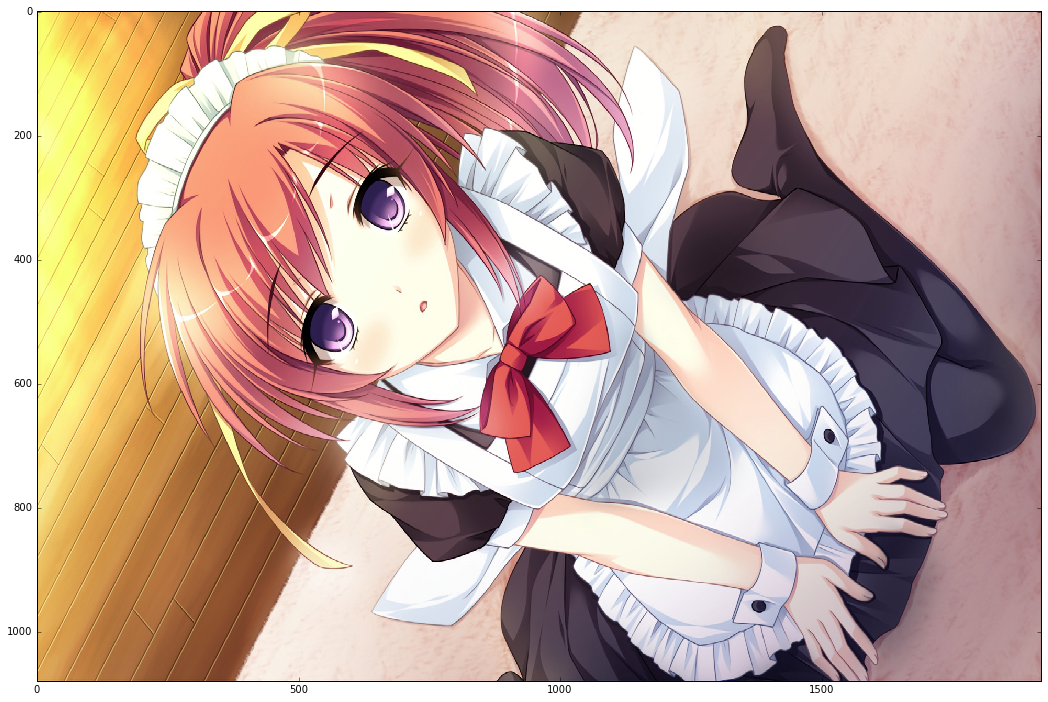

In [51]:
plt.figure(figsize = (18,12))
plt.imshow(sample[0],interpolation='nearest', aspect='auto')

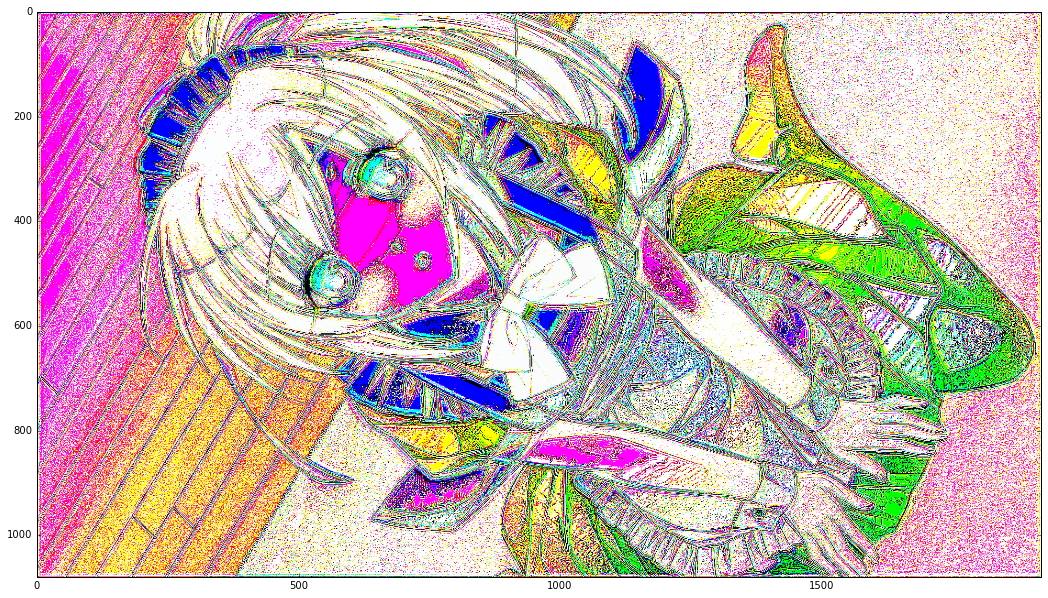

In [52]:
plt.figure(figsize = (18,12))
shape = sample[0].shape
diff_flat = abs(np.reshape(sample[0]-out_image_t[0],[-1]))
diff = np.reshape(diff_flat,shape)
plt.imshow(diff)

In [79]:
flat = np.reshape(out_image_t[0],[-1])
min(flat)

0

In [26]:
output_number = 25
rezoomed = misc.imresize(in_image[0],[OUTPUT_SIZE.h, OUTPUT_SIZE.w])
#output_number = output_number + 1
misc.imsave("../data/anime wallpapers/generated_output/"+str(output_number)+"_output.png", sample[0])
misc.imsave("../data/anime wallpapers/generated_output/"+str(output_number)+"_input.png", in_image_t[0])
misc.imsave("../data/anime wallpapers/generated_output/"+str(output_number)+"_original.png", out_image_t[0])
misc.imsave("../data/anime wallpapers/generated_output/"+str(output_number)+"_diff.png", sample[0]-out_image_t[0])
print("Created images with number = "+str(output_number))

Created images with number = 25


In [45]:
saver = tf.train.Saver(tf.get_collection(tf.GraphKeys.VARIABLES))
saver.save(sess, '../saves', global_step=1)

'../saves-1'

In [40]:
saver.restore(sess,'../saves-1')